In [1]:
from transformers import (
    HubertForSequenceClassification,
    HubertModel,
    HubertPreTrainedModel,
    Wav2Vec2FeatureExtractor,
)

from transformers.modeling_outputs import SequenceClassifierOutput

import librosa
import numpy as np
import pandas as pd
import torch

In [2]:
models_list = [
    "models/2000-samples/hubert-base-dusha-ft-0-layers",
    "models/2000-samples/hubert-base-dusha-ft-12-layers",
    "models/2000-samples/hubert-base-dusha-ft-12-layers-5ep",
    "models/2000-samples/hubert-base-dusha-ft-12-layers-10ep",
    "models/2000-samples/hubert-base-dusha-ft-12-layers-15ep",
    "models/8000-samples/hubert-base-dusha-ft-12-layers-3ep-8k",
    "models/8000-samples/hubert-base-dusha-ft-12-layers-5ep-8k",
    "models/hubert-base-dusha-ft-bin-clf",
    "models/hubert-base-dusha-ft-bin-clf-1000",
    "models/hubert-base-dusha-ft-bin-clf-1000-after-triplets-3000",
    "models/hubert-base-dusha-ft-bin-clf-after-triplets-4000",
]

In [3]:
model_id = models_list[7]

model = HubertForSequenceClassification.from_pretrained(
    model_id,
    local_files_only=True,
    output_hidden_states=True
)

In [13]:
model_id = models_list[10]

model = HubertClassificationAfterTriplet.from_pretrained(
    model_id,
    local_files_only=True,
    output_hidden_states=True
)

In [4]:
# labels_names = ["neutral", "angry", "positive", "sad"]
labels_names = ["positive", "sad"]
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/hubert-base-ls960")
sampling_rate = feature_extractor.sampling_rate

# predictions = torch.argmax(output.logits, dim=-1)
# print(labels_names[predictions.numpy()[0]])

In [8]:
df = pd.read_csv("../data/crowd_test_500.csv")
df.head()

,id,audio_path,features_path,emotion,label,duration
0,9e9961c53ca6eeb440b217e539fbf46c,dusha/crowd/crowd_test/wavs/9e9961c53ca6eeb440...,dusha/features/9e9961c53ca6eeb440b217e539fbf46...,neutral,0,5.82
1,0166f65a30354db8282682b1a280e64c,dusha/crowd/crowd_test/wavs/0166f65a30354db828...,dusha/features/0166f65a30354db8282682b1a280e64...,neutral,0,3.70
2,d49a6b560155831725a7bdc7d0a96099,dusha/crowd/crowd_test/wavs/d49a6b560155831725...,dusha/features/d49a6b560155831725a7bdc7d0a9609...,neutral,0,4.38
3,c6852b0925797612d7b6724da8cbe7b4,dusha/crowd/crowd_test/wavs/c6852b0925797612d7...,dusha/features/c6852b0925797612d7b6724da8cbe7b...,neutral,0,8.58
4,64a7aa17132c3e4b7be1aaed5fc88090,dusha/crowd/crowd_test/wavs/64a7aa17132c3e4b7b...,dusha/features/64a7aa17132c3e4b7be1aaed5fc8809...,positive,2,5.06


In [5]:
# train_df = pd.read_csv("../data/crowd_train_bin_500.csv")
train_df = pd.read_csv("../data/crowd_train_bin_2000.csv")
test_df = pd.read_csv("../data/crowd_test_bin_500.csv")

In [33]:
n_samples = 500
df_reduce = df.groupby(['emotion']).head(n_samples).reset_index(drop=True)
df_reduce[['emotion']].groupby('emotion').value_counts()

emotion
angry       500
neutral     500
positive    500
sad         500
Name: count, dtype: int64

In [6]:
import torch.nn as nn
from torch.nn import CrossEntropyLoss

class HubertClassificationAfterTriplet(HubertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.config = config

        self.hubert = HubertModel(config)
        self.fc1 = nn.Linear(config.hidden_size, config.classifier_proj_size)
        self.classifier = nn.Linear(config.classifier_proj_size, config.num_labels)

        self.post_init()

    def forward(
        self,
        input_values,
        labels=None,
        attention_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        return_loss=True,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        output_hidden_states = True if self.config.use_weighted_layer_sum else output_hidden_states

        outputs = self.hubert(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        relu = nn.ReLU(inplace=True)

        hidden_state = outputs.last_hidden_state
        hidden_state = self.fc1(hidden_state.mean(dim=1))
        hidden_state = relu(hidden_state)
        logits = self.classifier(hidden_state)

        loss = None
        if labels is not None:
            loss_fn = CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.config.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [7]:
# Получение выхода с модели
def get_output_for_audio(audio, feature_extractor, model, sampling_rate=16000):
    audio_array = librosa.load(
        audio,
        sr=sampling_rate,
        mono=False
    )[0]
    
    input_values = feature_extractor(
        audio_array,
        sampling_rate=sampling_rate,
        return_tensors="pt"
    ).input_values

    output = model(input_values)

    return output

# Получение массива со средними значениями признаков каждого аудиофайла
def get_mean_features_and_labels(df, model, feature_extractor, sampling_rate=16000):
    output = get_output_for_audio(f'../{df["audio_path"][0]}', feature_extractor, model, sampling_rate)
    hidden_state = output.hidden_states[-1].detach().numpy()[0]
    hidden_state = hidden_state.mean(axis=0)

    features_list = [[hidden_state]]
    labels_list = [df['label'][0]]

    for index, row in df.iterrows():
        if (index == 0):
            continue
        
        output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, sampling_rate)
        hidden_state = output.hidden_states[-1].detach().numpy()[0]
        hidden_state = hidden_state.mean(axis=0)
        
        features_list.append([hidden_state])
        labels_list.append(row['label'])
    
    data = np.concatenate(features_list)
    labels = np.array(labels_list)
    
    return data, labels

# Получение массива со значениями признаков
def get_features_and_labels(df, model, feature_extractor, sampling_rate=16000):
    output = get_output_for_audio(f'../{df["audio_path"][0]}', feature_extractor, model, sampling_rate)
    hidden_state = output.hidden_states[-1].detach().numpy()[0]
    
    features_list = [hidden_state]
    labels_list = [[df['label'][0] for _ in range(hidden_state.shape[0])]]

    for index, row in df.iterrows():
        if (index == 0):
            continue
        
        output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, sampling_rate)
        hidden_state = output.hidden_states[-1].detach().numpy()[0]

        features_list.append(hidden_state)
        labels_list.append([row['label'] for _ in range(hidden_state.shape[0])])
    
    data = np.concatenate(features_list)
    labels = np.concatenate(labels_list)
    
    return data, labels

def get_logits_and_labels(df, model, feature_extractor, sampling_rate=16000):
    output = get_output_for_audio(f'../{df["audio_path"][0]}', feature_extractor, model, sampling_rate)
    logits = output['logits'].detach().numpy()[0]

    logits_list = [[logits]]
    labels_list = [df['label'][0]]

    for index, row in df.iterrows():
        if (index == 0):
            continue
        
        output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, sampling_rate)
        logits = output['logits'].detach().numpy()[0]
        
        logits_list.append([logits])
        labels_list.append(row['label'])
    
    data = np.concatenate(logits_list)
    labels = np.array(labels_list)
    
    return data, labels

In [63]:
# data, labels = get_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)
data, labels = get_mean_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)

## Визуализация результатов

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

sns.set()

import umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [9]:
import matplotlib as mpl
import matplotlib.colors as mcolors

def color_map_color(value, cmap_name='viridis', vmin=0, vmax=1):
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = mpl.colormaps[cmap_name]
    rgb = cmap(norm(abs(value)))[:3]
    color = mcolors.rgb2hex(rgb)
    return color

def get_patches(colormap='viridis'):
    pathches = [
        # mpatches.Patch(color=color_map_color(0, colormap, 0, 3), label='neutral'),
        # mpatches.Patch(color=color_map_color(1, colormap, 0, 3), label='angry'),
        # mpatches.Patch(color=color_map_color(2, colormap, 0, 3), label='positive'),
        # mpatches.Patch(color=color_map_color(3, colormap, 0, 3), label='sad'),
        mpatches.Patch(color=color_map_color(0, colormap, 0, 1), label='positive'),
        mpatches.Patch(color=color_map_color(1, colormap, 0, 1), label='sad'),
    ]

    return pathches

def plot_2d(data, labels, title=""):
    pca_2d = PCA(n_components=2)
    pca_2d_data = pca_2d.fit_transform(data)

    fig, ax = plt.subplots()
    ax.scatter(x=pca_2d_data[:, 0], y=pca_2d_data[:, 1], c=labels, cmap='viridis')
    
    ax.legend(handles=get_patches())
    ax.set_title(title)
    
    plt.show()

def plot_3d(data, labels, title=""):
    pca_3d = PCA(n_components=3)
    pca_3d_data = pca_3d.fit_transform(data)

    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    
    ax.scatter(xs=pca_3d_data[:, 0], ys=pca_3d_data[:, 1], zs=pca_3d_data[:, 2], c=labels, cmap='viridis')
    ax.legend(handles=get_patches())
    ax.set_title(title)
        
    plt.show()

### Бинарная классификация

#### models/hubert-base-dusha-ft-bin-clf-1000

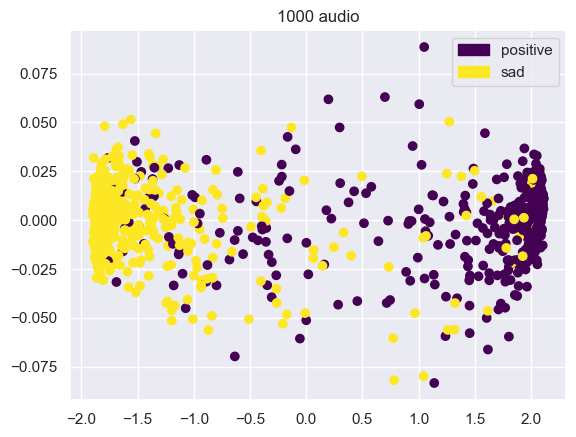

In [28]:
data, labels = get_logits_and_labels(train_df, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"1000 audio")

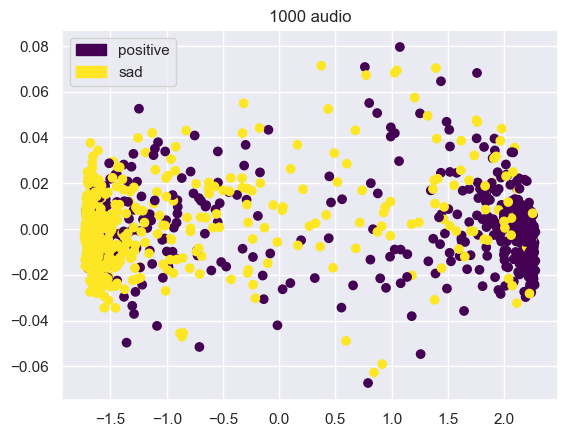

In [18]:
data, labels = get_logits_and_labels(test_df, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"1000 audio")

#### models/hubert-base-dusha-ft-bin-clf

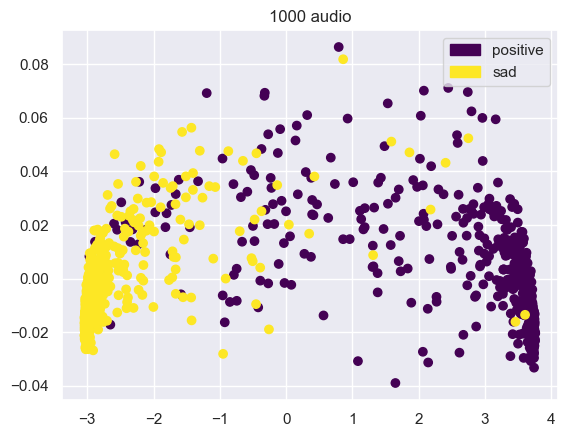

In [10]:
n_samples = 500
df_reduce = train_df.groupby(['emotion']).sample(n_samples).reset_index(drop=True)

data, labels = get_logits_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"1000 audio")

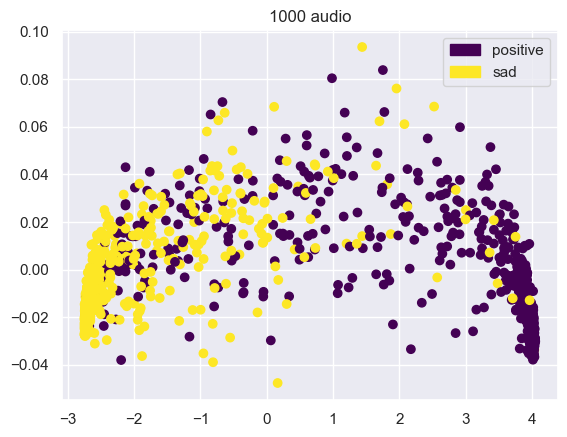

In [11]:
data, labels = get_logits_and_labels(test_df, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"1000 audio")

#### models/hubert-base-dusha-ft-bin-clf-1000-after-triplets-3000

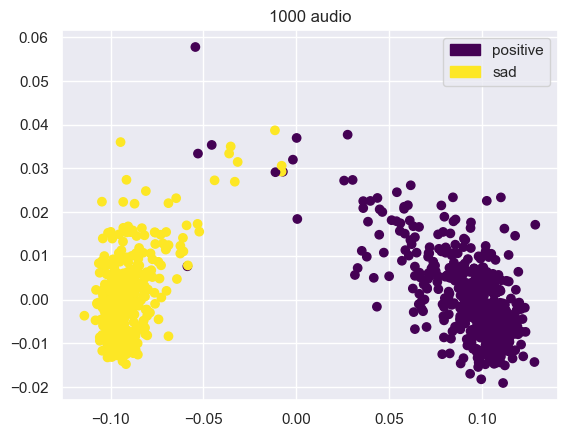

In [26]:
data, labels = get_logits_and_labels(train_df, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"1000 audio")

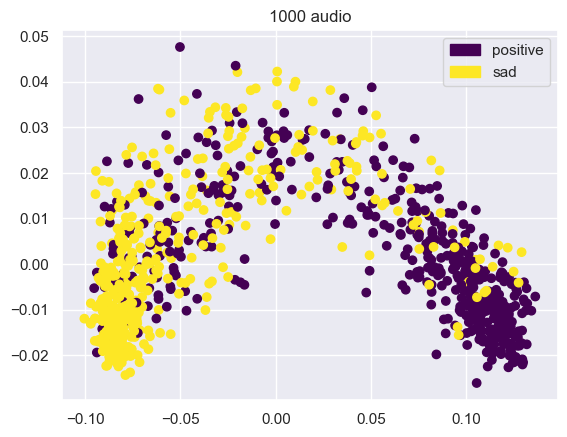

In [25]:
data, labels = get_logits_and_labels(test_df, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"1000 audio")

#### models/hubert-base-dusha-ft-bin-clf-after-triplets-4000

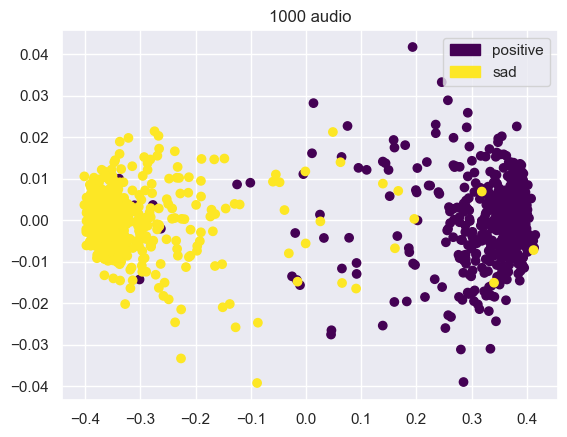

In [14]:
# n_samples = 500
# df_reduce = train_df.groupby(['emotion']).sample(n_samples).reset_index(drop=True)

data, labels = get_logits_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"1000 audio")

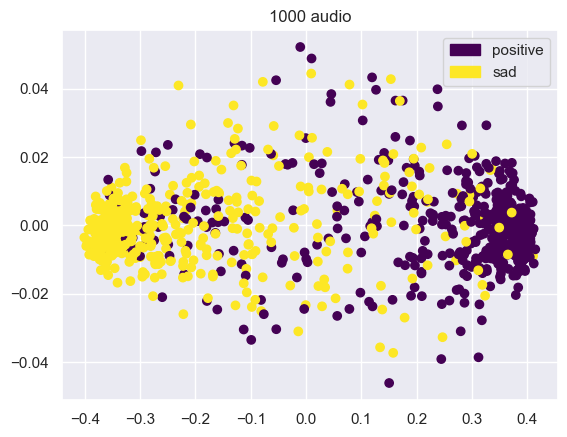

In [15]:
data, labels = get_logits_and_labels(test_df, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"1000 audio")

-----

In [19]:
n_samples = 150
df_reduce = test_df.groupby(['emotion']).head(n_samples).reset_index(drop=True)

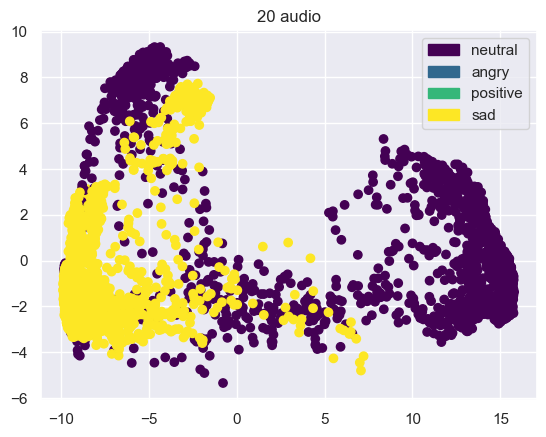

In [18]:
data, labels = get_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

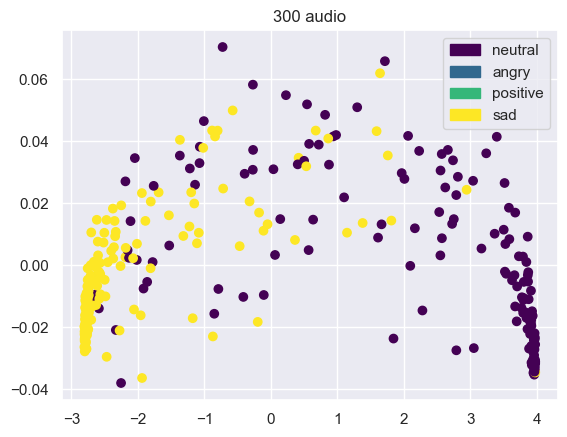

In [20]:
data, labels = get_logits_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d(data, labels, f"{n_samples * 2} audio")

## 2D

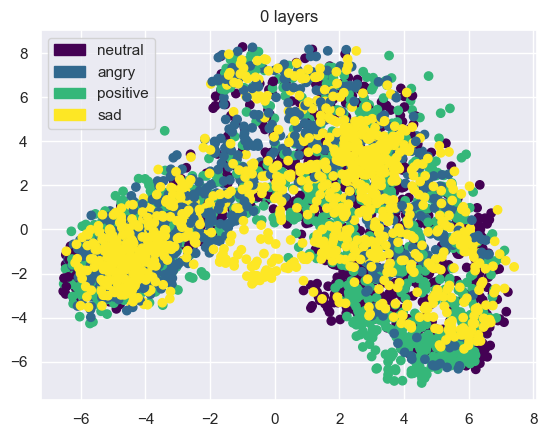

In [42]:
plot_2d(data, labels, "0 layers")

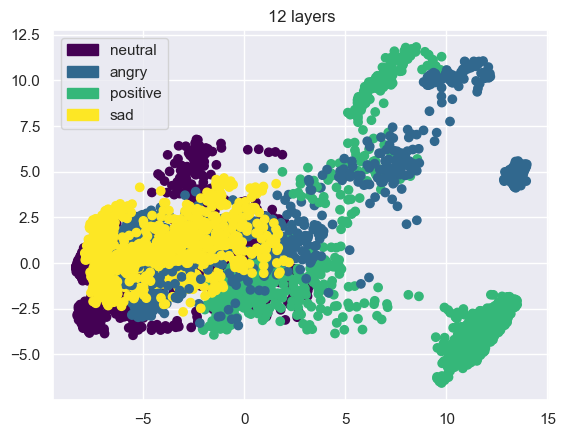

In [35]:
plot_2d(data, labels, "12 layers")

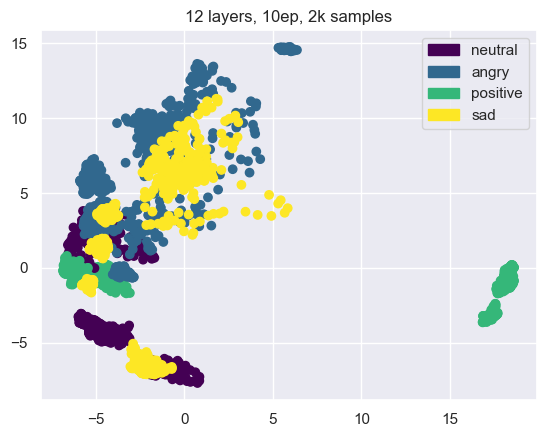

In [47]:
plot_2d(data, labels, "12 layers, 10ep, 2k samples")

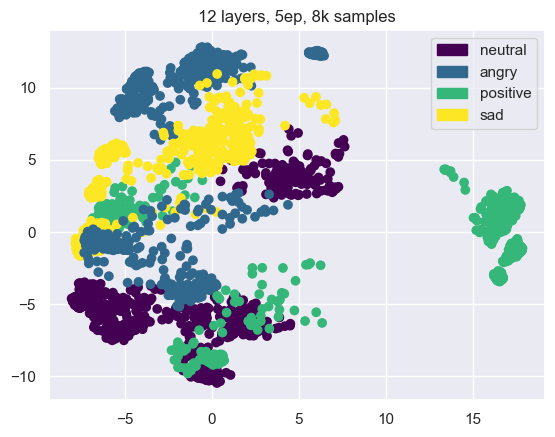

In [51]:
plot_2d(data, labels, "12 layers, 5ep, 8k samples")

## 3D

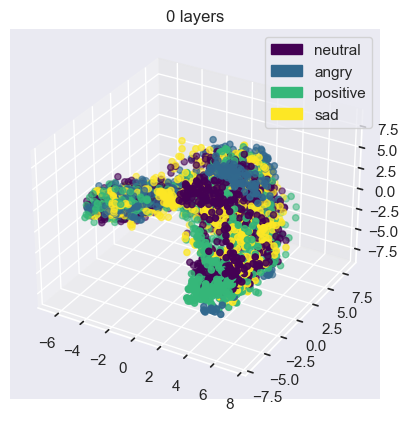

In [43]:
plot_3d(data, labels, "0 layers")

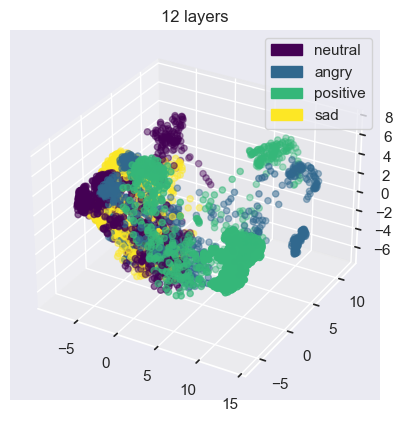

In [37]:
plot_3d(data, labels, "12 layers")

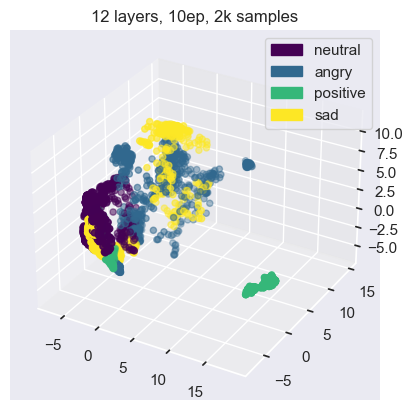

In [48]:
plot_3d(data, labels, "12 layers, 10ep, 2k samples")

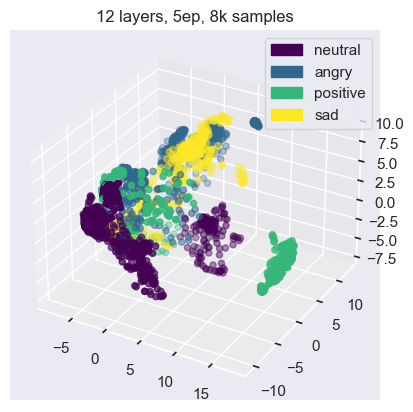

In [52]:
plot_3d(data, labels, "12 layers, 5ep, 8k samples")

### Средние значения признаков

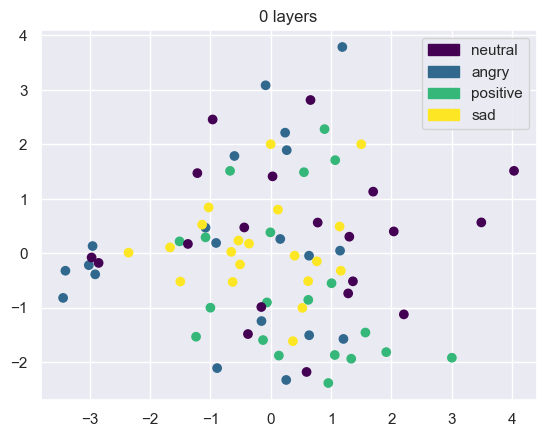

In [57]:
plot_2d(data, labels, "0 layers")

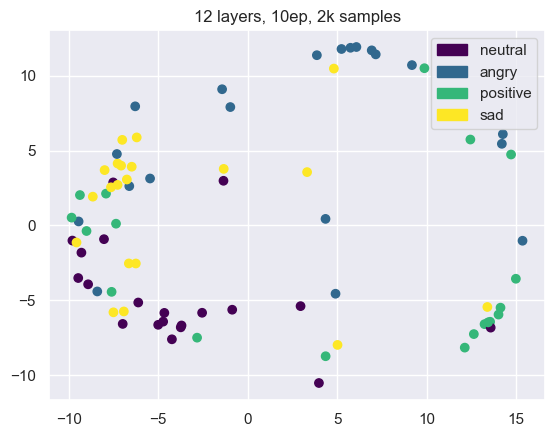

In [61]:
plot_2d(data, labels, "12 layers, 10ep, 2k samples")

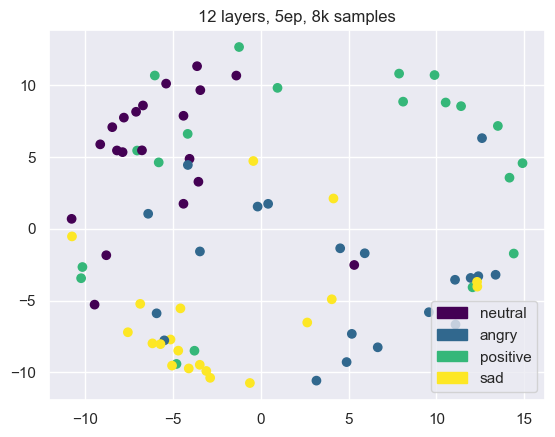

In [64]:
plot_2d(data, labels, "12 layers, 5ep, 8k samples")

### HuBERT с TripletLoss

In [18]:
# Получение массива со средними значениями признаков каждого аудиофайла
def get_mean_features_and_labels(df, model, feature_extractor, sampling_rate=16000):
    output = get_output_for_audio(f'../{df["audio_path"][0]}', feature_extractor, model, sampling_rate)
    hidden_state = output.last_hidden_state.detach().numpy()[0]
    hidden_state = hidden_state.mean(axis=0)

    features_list = [[hidden_state]]
    labels_list = [df['label'][0]]

    for index, row in df.iterrows():
        if (index == 0):
            continue
        
        output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, sampling_rate)
        hidden_state = output.last_hidden_state.detach().numpy()[0]
        hidden_state = hidden_state.mean(axis=0)
        
        features_list.append([hidden_state])
        labels_list.append(row['label'])
    
    data = np.concatenate(features_list)
    labels = np.array(labels_list)
    
    return data, labels

# Получение массива со значениями признаков
def get_features_and_labels(df, model, feature_extractor, sampling_rate=16000):
    output = get_output_for_audio(f'../{df["audio_path"][0]}', feature_extractor, model, sampling_rate)
    hidden_state = output.last_hidden_state.detach().numpy()[0]
    
    features_list = [hidden_state]
    labels_list = [[df['label'][0] for _ in range(hidden_state.shape[0])]]

    for index, row in df.iterrows():
        if (index == 0):
            continue
        
        output = get_output_for_audio(f'../{row["audio_path"]}', feature_extractor, model, sampling_rate)
        hidden_state = output.last_hidden_state.detach().numpy()[0]

        features_list.append(hidden_state)
        labels_list.append([row['label'] for _ in range(hidden_state.shape[0])])
    
    data = np.concatenate(features_list)
    labels = np.concatenate(labels_list)
    
    return data, labels

In [29]:
def plot_2d_triple(data, labels, title=""):
    reducers = [
        PCA(n_components=2),
        umap.UMAP(),
        TSNE(n_components=2, learning_rate='auto', init='random', perplexity=5)
    ]
    
    titles = ["PCA", "UMAP", "TSNE"]

    fig, ax = plt.subplots(1, 3)
    fig.set_figheight(4)
    fig.set_figwidth(12)
    for i in range(len(reducers)):
        reduced_data = reducers[i].fit_transform(data)
        ax[i].scatter(x=reduced_data[:, 0], y=reduced_data[:, 1], c=labels, cmap='viridis')
        ax[i].legend(handles=get_patches())
        ax[i].set_title(titles[i])

    plt.tight_layout()
    plt.show()

In [14]:
models = [
    "models/triplets/hubert-base-dusha-ft-triplets-m1-mean",
    "models/triplets/hubert-base-dusha-ft-triplets-m05-mean",
    "models/triplets/hubert-base-dusha-ft-triplets-m5-mean",
    "models/triplets/custom-hubert-base-dusha-ft-triplets-m1-mean",
]

Some weights of the model checkpoint at facebook/hubert-base-ls960 were not used when initializing HubertModel: ['encoder.pos_conv_embed.conv.weight_g', 'encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing HubertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing HubertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of HubertModel were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for pre

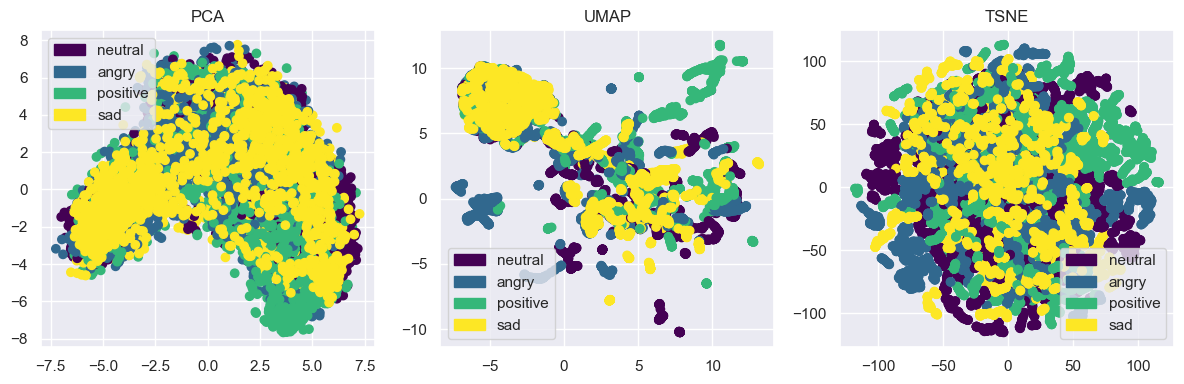

In [41]:
n_samples = 10
df_reduce = df.groupby(['emotion']).head(n_samples).reset_index(drop=True)

model = HubertModel.from_pretrained("facebook/hubert-base-ls960")
data, labels = get_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d_triple(data, labels)

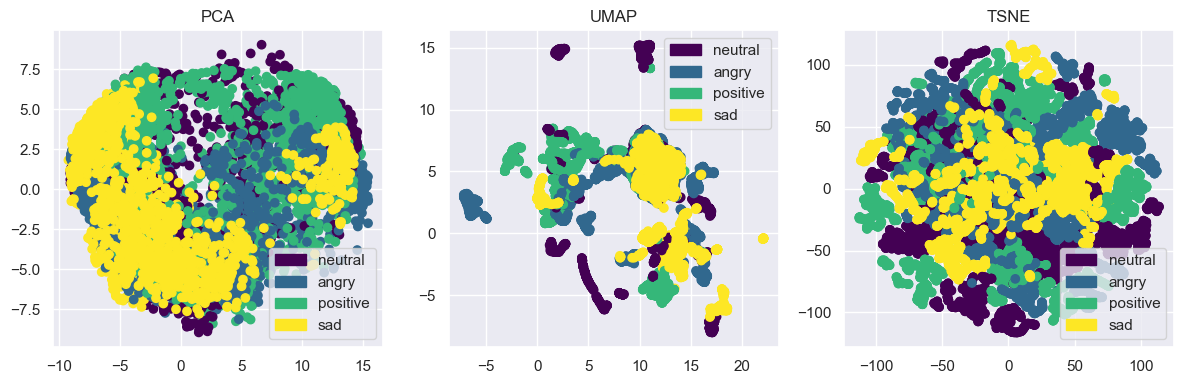

In [42]:
n_samples = 10
df_reduce = df.groupby(['emotion']).head(n_samples).reset_index(drop=True)

model = HubertModel.from_pretrained(models[2], local_files_only=True)
data, labels = get_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d_triple(data, labels)

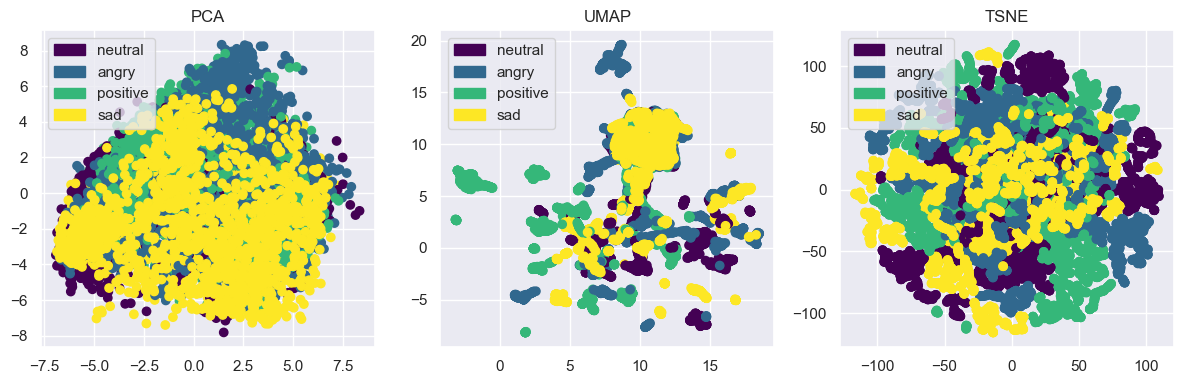

In [43]:
model = HubertModel.from_pretrained(models[0], local_files_only=True)
data, labels = get_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d_triple(data, labels)

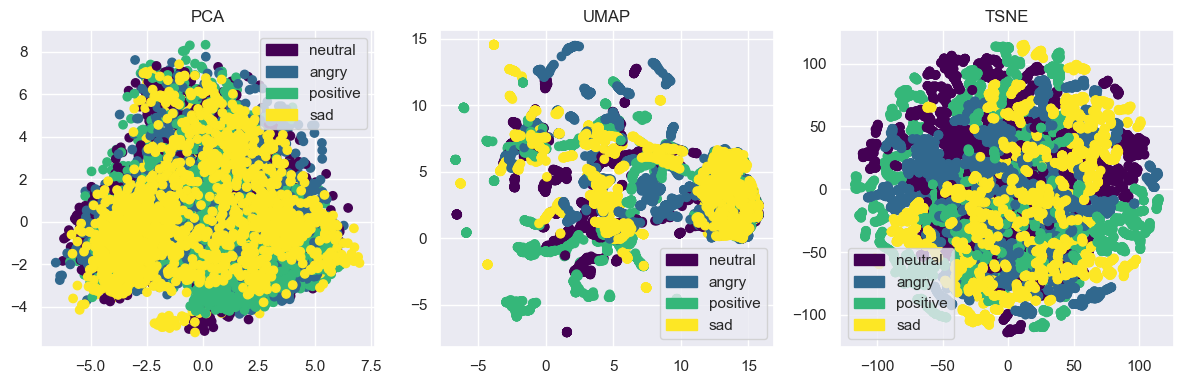

In [44]:
model = HubertModel.from_pretrained(models[1], local_files_only=True)
data, labels = get_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d_triple(data, labels)

### Средние значения признаков

In [35]:
n_samples = 200
df_reduce = df.groupby(['emotion']).head(n_samples).reset_index(drop=True)

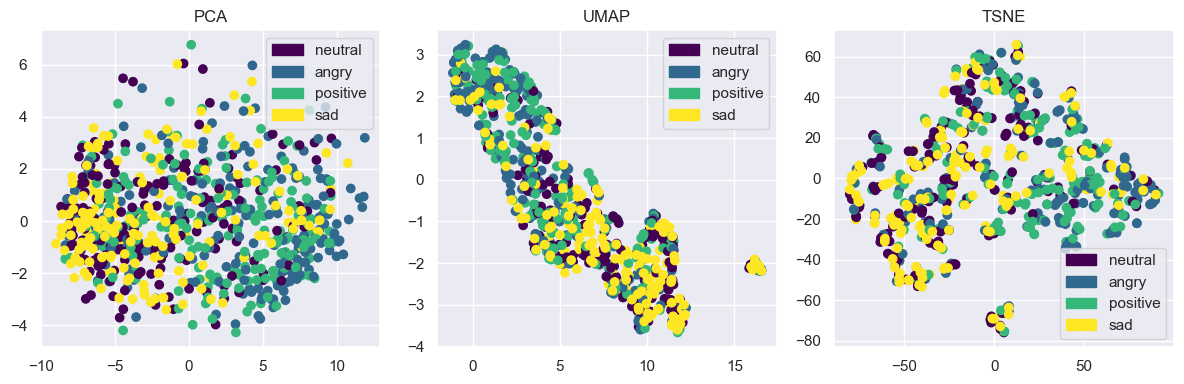

In [36]:
model = HubertModel.from_pretrained(models[2], local_files_only=True)
data, labels = get_mean_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d_triple(data, labels)

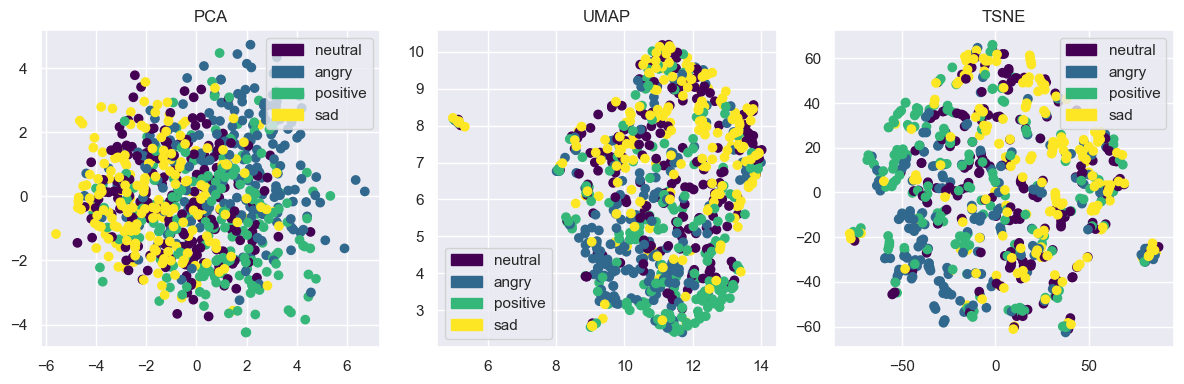

In [37]:
model = HubertModel.from_pretrained(models[0], local_files_only=True)
data, labels = get_mean_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d_triple(data, labels)

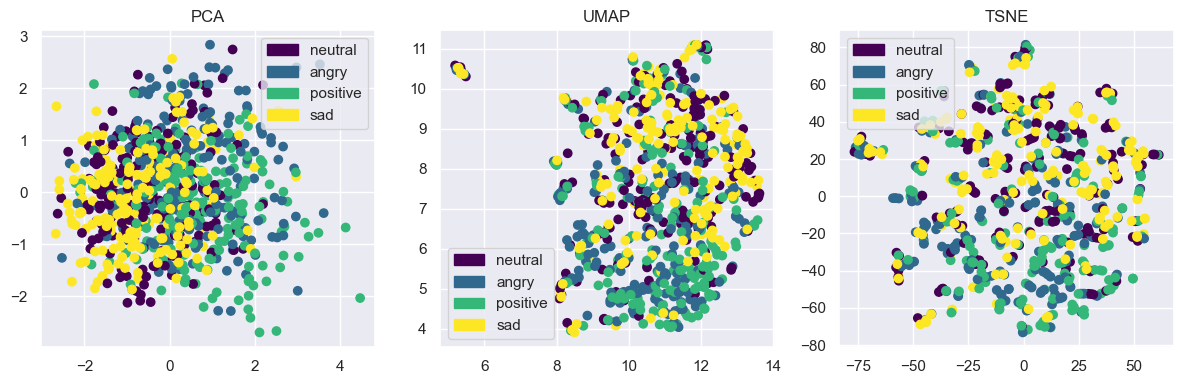

In [38]:
model = HubertModel.from_pretrained(models[1], local_files_only=True)
data, labels = get_mean_features_and_labels(df_reduce, model, feature_extractor, sampling_rate)
plot_2d_triple(data, labels)

In [9]:
# model = HubertModel.from_pretrained("facebook/hubert-base-ls960", output_hidden_states=True)
# model = HubertForSequenceClassification.from_pretrained(
#     "models/8000-samples/hubert-base-dusha-ft-12-layers-5ep-8k",
#     # "models/triplets/hubert-base-dusha-ft-triplets-m1-mean",
#     local_files_only=True,
#     output_hidden_states=True
# )

In [11]:
output_1 = get_output_for_audio(f"../{df['audio_path'][1]}", feature_extractor, model)
output_2 = get_output_for_audio(f"../{df['audio_path'][4]}", feature_extractor, model)
output_3 = get_output_for_audio(f"../{df['audio_path'][3]}", feature_extractor, model)

pdist = torch.nn.PairwiseDistance(p=2)
dist_1_2 = pdist(output_1.hidden_states[-1].mean(dim=1), output_2.hidden_states[-1].mean(dim=1))
dist_1_3 = pdist(output_1.hidden_states[-1].mean(dim=1), output_3.hidden_states[-1].mean(dim=1))
dist_2_3 = pdist(output_2.hidden_states[-1].mean(dim=1), output_3.hidden_states[-1].mean(dim=1))

print(dist_1_2, dist_1_3, dist_2_3)

tensor([23.1951], grad_fn=<NormBackward1>) tensor([10.4148], grad_fn=<NormBackward1>) tensor([23.4741], grad_fn=<NormBackward1>)


In [14]:
loss = torch.nn.TripletMarginLoss(margin=15.0)
loss(output_1.hidden_states[-1].mean(dim=1), output_3.hidden_states[-1].mean(dim=1), output_2.hidden_states[-1].mean(dim=1))

tensor(2.2197, grad_fn=<MeanBackward0>)